## Задача - создать ИИ-бота для карточной настольной игры "7 Wonders Duel"

### Подзадача - создать простую моделку-пенек "Policy", которая:

- выбирает оптимальное действие на основе текущего расклада сил: action=Policy(state)
- обучается supervised способом на основе действий реальных людей в записанных играх
- подходит для доигрывания в алгоритме Monte Carlo Tree Search
- подходит для некоторого ансамбля
- имеет хорошу производительность (маленькое время отработки инференса)


- *обучалась [by https://github.com/Laggg] и работала для первой версии движка 7wd на 03.2022
- *почти все идеи реализованного подхода были перенесены во вторую версию движка 7wd 04.2022 [by https://github.com/dfomin]


### Реализованный подход: ~60-62% accuracy

- многоклассовая классификация (40 классов)
- модель: несколько линейных слоев
- output: 40 возможных позиций, т.е. 20 вариантов взять карту + 20 вариантов сбросить карту с текущего поля
- **20 вариантов нужно интерпретировать так: построить/сбросить карту с положением {0,1,2,...,19} в раскладке текущей эпохи** - такой таргет дал буст около +10% метрики (см. конец этого ноутбука, раздел additional)
- input: признаки мощи обоих игроков и информация о поле с картами - каждая карта имеет свой эмбеддинг
- эмбеддинг карты состоит из семантической части с2v и из части с ее стоимостью и полезностью
- семантическую часть эмбеддинга находим с помощью w2v, основываясь на том, какие комбинации карт собирает игрок чаще всего в своем городе (подобно item2vec в ритейле для продуктовой корзины), дополнительно учитывается последовательность взяния карт игроком.
- если карта открыта (рубашкой вниз) и доступна (в этот ход можно ее взять), то семантическая часть эмбеддинга этой карты домножается на {+1}
- если карта открыта (рубашкой вниз) и недоступна (заслонена другими картами), то семантическая часть эмбеддинга этой карты домножается на {-1}
- если карта закрыта (рубашкой вверх), то весь эмбеддинг этой карты заменяется вектором из единиц
- если карта была уже взята каким либо игроком во время текущей эпохи, то весь эмбеддинг этой карты заменяется вектором из нулей
- все input признаки вытягивались в один длинный вектор
- дополнительно реализован подход фильтрации выходов модели для финального выбора действия, в котором выбирается argmax не по всему output-вектору, а по вектору, который состоит только из открытых+доступных карт в текущем моменте игры (финальный выбор никогда не окажется невозможным действием)
- основные пункты этого списка отражены в рисунке ниже:

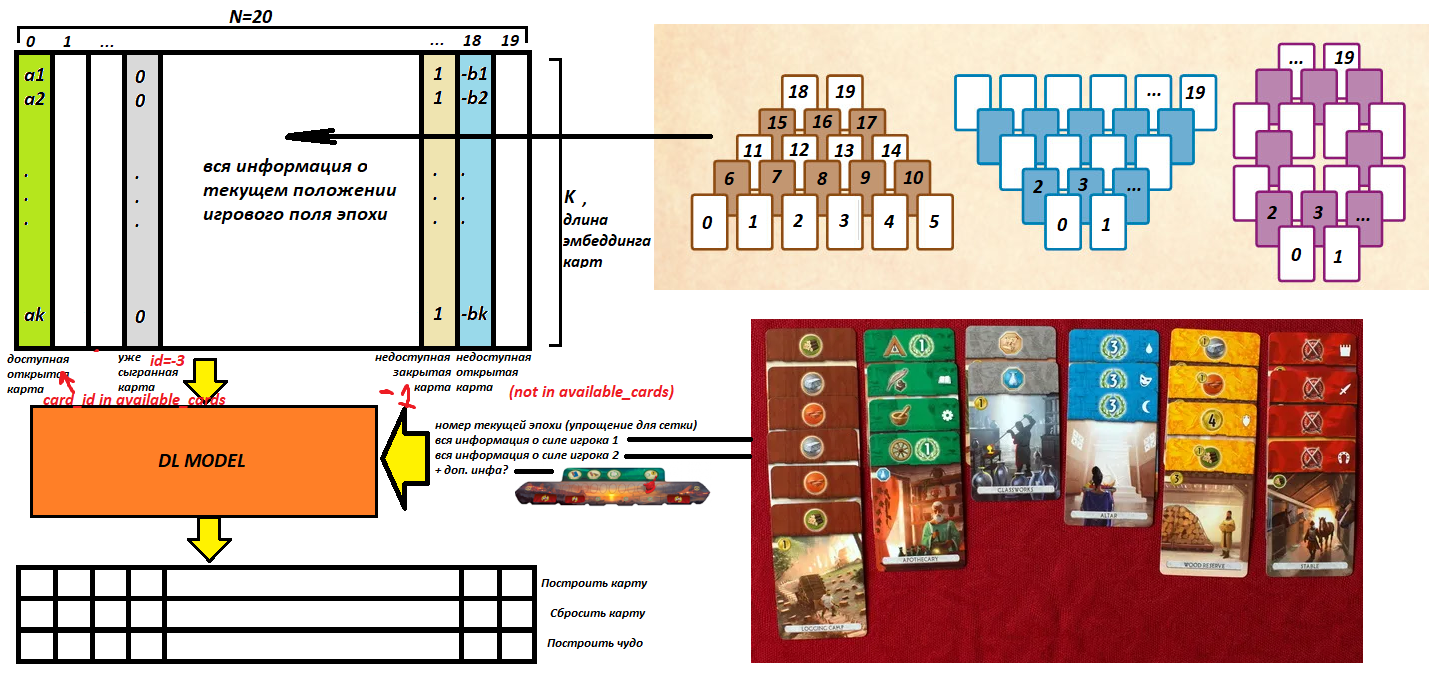

## Libs

In [1]:
import sys
sys.path.insert(0, '..')
sys.path.insert(0, '../../7wd-engine/')

import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from swd_bot.state_features import StateFeatures
from swd.entity_manager import EntityManager

CARDS_COUNT = EntityManager.cards_count()
#print(CARDS_COUNT) # 73=23(I_ep)+23(II_ep)+27(III_ep)

from swd.bonuses import ImmediateBonus, RESOURCES
from swd.cards import Card
from swd.entity_manager import EntityManager

import pandas as pd
import numpy as np
import gensim #!pip install gensim #installed gensim-4.1.2 smart-open-5.2.1
from gensim.models import KeyedVectors

params = {"c2v_SIZE": 32,
          "WINDOW": 5,
          "DEVICE": "cuda:0",
          "BATCH": 32,
         }

## card2vec

In [5]:
#============data preprocessing======================
df = pd.read_csv('words.csv')
#print(df.shape, np.unique(df['path']).shape)
#df = df[df.age == 2]

data_lines = []
for x in df['words']:
    #for i in range(10):
    y = x.split('_')
    #random.shuffle(y)
    data_lines.append(y) 
#data_lines[:3]

#===========train_card2vec=============================
#https://radimrehurek.com/gensim/models/word2vec.html
c2v = gensim.models.Word2Vec(sentences=data_lines,
                             sg=1,            # 1: skipgram, 0:CBOW
                             vector_size=params["c2v_SIZE"], # emb size
                             window=params["WINDOW"],
                             min_count=1,
                             workers=4)
#c2v.save("7wd_card2vec.model")
#c2v = gensim.models.Word2Vec.load("7wd_card2vec.model")
#print(c2v.wv.most_similar('0', topn=5))
#print(c2v.wv['0'])

#c2v.wv.save("7wd_card2vec.wordvectors")
#wv = KeyedVectors.load("7wd_card2vec.wordvectors", mmap='r')
#print(wv.most_similar('0', topn=5))
#print(wv['0'])
#=========================================================

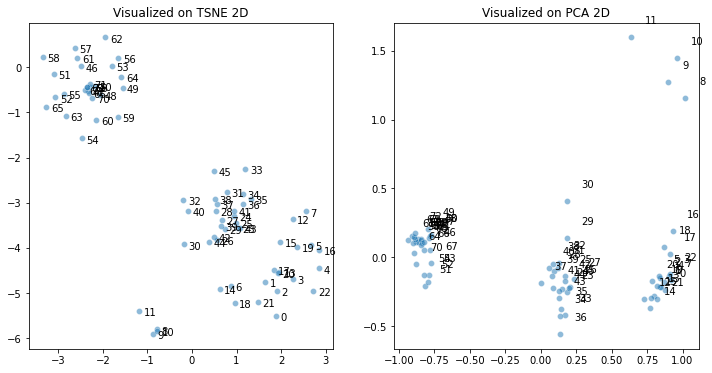

In [6]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

X = []
wv = KeyedVectors.load("7wd_card2vec_best.wordvectors", mmap='r')
for card in range(CARDS_COUNT):
    X.append(wv[str(card)])
X = np.array(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.copy())
#print(X.shape, X_pca.shape) #(73, 32) (73, 2)
X_tsne = TSNE(n_components=2,random_state=42).fit_transform(X.copy())
#print(X.shape, X_tsne.shape) #(73, 32) (73, 2)

fig, ax = plt.subplots(1, 2, figsize=(12,6))
sns.scatterplot(x=X_tsne[:,0],y=X_tsne[:,1],legend="full",alpha=0.5,ax=ax[0]) 
sns.scatterplot(x=X_pca[:,0],y=X_pca[:,1],legend="full",alpha=0.5,ax=ax[1])
for card in range(CARDS_COUNT):
    ax[0].text(X_tsne[card,0]+0.1, X_tsne[card,1]-0.1, str(card), fontsize=10)
    ax[1].text(X_pca[card,0]+0.1, X_pca[card,1]+0.1, str(card), fontsize=10)
    
ax[0].set_title('Visualized on TSNE 2D')
ax[1].set_title('Visualized on PCA 2D');

## DataLoader: features & target

In [2]:
def card_features(card: Card) -> np.ndarray: # =card.bonuses
    result = np.zeros(1 + len(card.price.resources) + 1 + len(card.bonuses) + len(ImmediateBonus))
    result[0] = card.price.coins # условие строительства [монеты]
    result[1: 1 + len(RESOURCES)] = card.price.resources # условие строительства [ресурсы]
    #result[1 + len(RESOURCES)] = card.price.chain_symbol # условие строительства [бесплатно по цепочке]
    result[2 + len(RESOURCES): 2 + len(RESOURCES) + len(card.bonuses)] = card.bonuses # бонусы долгоиграющие
    result[2 + len(RESOURCES) + len(card.bonuses):] = [card.immediate_bonus.get(x, 0) for x in ImmediateBonus] # мгновен.
    return result

#EntityManager.card(47)
len_bonuces = len(card_features(card=EntityManager.card(0)))
len_bonuces

84

In [7]:
def flatten_features(x):
    output = []
    output.append(x["age"])
    output.append(x["current_player"]) # чей ход
    output.extend(x["tokens"]) # ohe жетонов науки
    output.append(x["military_pawn"]) # {-9...+9}
    output.extend(x["military_tokens"]) # 4 плашки
    output.append(x["game_status"]) # 2 - обычный ход, или другое число - взять жетон, конец игры и тд
    for i in range(2):
        output.append(x["players"][i]["coins"]) # деньги
        output.extend(x["players"][i]["unbuilt_wonders"]) # непостроенные чуда
        output.extend(x["players"][i]["bonuses"]) # все ресурсы/бонусы с текущих построек игрока (без id карт)
    
    for card_id in x["cards_board"]:
        if card_id >= 0:
            c2v = wv[str(card_id)]
            if card_id not in x["available_cards"]:
                c2v = -1*c2v
            cb = card_features(card=EntityManager.card(0))/10 #эмбеддинг карты
            c2v = np.concatenate([c2v, cb])
            #print(c2v.shape, cb.shape) # 92=8+84
        elif card_id==-1:
            c2v = np.ones(params["c2v_SIZE"]+len_bonuces) 
        else:
            c2v = np.zeros(params["c2v_SIZE"]+len_bonuces) 
        output.extend(c2v.tolist())

#     for card_id in x["cards_board"]:
#         if card_id >= 0:
#             c2v = F.one_hot(torch.tensor(card_id), num_classes=73)
#         else:
#             c2v = torch.zeros(73)
#         output.extend(c2v.tolist())
        
    #print(x["age"])
    #print('all ', x["cards_board"])
    #print('active open ', x["available_cards"])
    #print()

    return output


class StatesDataset(Dataset):
    def __init__(self, states, actions):
        self.states = states
        self.actions = actions
    
    def __len__(self):
        return len(self.states)
    
    def __getitem__(self, index):
        action = self.actions[index]
        action_id = action.card_id + (0 if str(action)[0] == "B" else CARDS_COUNT)
        
        state = self.states[index]
        x = StateFeatures.extract_state_features_dict(state)                
        
        c_id = -1
        if action_id in x["available_cards"]: # берем активную карту
            for i in range(20):
                c = x["cards_board"][i]
                if c ==  action_id:
                    c_id = i
                    break
        else:                                 # сбрасываем одну из активных карт
            action_id = action_id-73
            for i in range(20):
                c = x["cards_board"][i]
                if c ==  action_id:
                    c_id = i+20
                    break
        
        active_cards = torch.tensor([1 if crd in x["available_cards"] else 0 for crd in x["cards_board"]]*2,
                                     dtype=torch.long)
        features = torch.tensor(flatten_features(x), dtype=torch.float)
        target = torch.tensor(c_id, dtype=torch.long)
        
        return features, target, active_cards

In [8]:
with open("states.pkl", "rb") as f:
    states = pickle.load(f)
with open("actions.pkl", "rb") as f:
    actions = pickle.load(f)
    
dataset = StatesDataset(states, actions)
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])


train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=params['BATCH'],
                                           shuffle=True,
                                           drop_last=True,
                                           num_workers=0)
val_loader = torch.utils.data.DataLoader(test_dataset,
                                         batch_size=params['BATCH'],
                                         shuffle=False,
                                         drop_last=False,
                                         num_workers=0)

# a - и доска, и инфа об игре
# b - target
#a, b, c = iter(val_loader).next()
#a.size(), b.size(), c.size() #(torch.Size([32, 2482]), torch.Size([32]), torch.Size([32, 40]))

## DL model training

In [11]:
class Net(nn.Module):
    def __init__(self, in_features: int):
        super().__init__()
        self.linear1 = nn.Linear(in_features, 300)
        self.linear2 = nn.Linear(300, 20 * 2)
    
    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return x

In [13]:
model = Net(2482).to(params['DEVICE']) # 1982 1622 802
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


for epoch in range(20):
    running_loss = 0.0
    count = 0
    for i, data in enumerate(train_loader):
        inputs, labels, _ = data
        
        optimizer.zero_grad()

        outputs = model(inputs.to(params['DEVICE']))
        loss = criterion(outputs, labels.to(params['DEVICE']))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        count += 1

    with torch.no_grad():
        correct_pred = 0
        total_pred = 0
        for i, data in enumerate(val_loader):
            inputs, labels, act_crd = data
            labels = labels.to(params['DEVICE'])
            act_crd = act_crd.to(params['DEVICE'])
            outputs = model(inputs.to(params['DEVICE']))
            
            #_, predictions = torch.max(outputs, 1)
            _, predictions = torch.max(F.softmax(outputs, dim=1)*act_crd, 1)
            
            for label, prediction in zip(labels, predictions.to(params['DEVICE'])):
                if label == prediction:
                    correct_pred += 1
                total_pred += 1

    print(f'[{epoch + 1}] loss: {running_loss / count:.3f}, Accuracy: {round(100 * correct_pred / total_pred)}%')
    running_loss = 0.0
    count = 0

print('Finished Training')

[1] loss: 1.363, Accuracy: 54%
[2] loss: 1.113, Accuracy: 57%
[3] loss: 1.046, Accuracy: 57%
[4] loss: 1.006, Accuracy: 58%
[5] loss: 0.977, Accuracy: 60%
[6] loss: 0.958, Accuracy: 60%
[7] loss: 0.940, Accuracy: 60%
[8] loss: 0.926, Accuracy: 61%
[9] loss: 0.915, Accuracy: 60%
[10] loss: 0.903, Accuracy: 61%
[11] loss: 0.897, Accuracy: 62%
[12] loss: 0.889, Accuracy: 61%
[13] loss: 0.879, Accuracy: 61%
[14] loss: 0.872, Accuracy: 62%
[15] loss: 0.867, Accuracy: 61%
[16] loss: 0.861, Accuracy: 61%
[17] loss: 0.853, Accuracy: 61%
[18] loss: 0.849, Accuracy: 62%
[19] loss: 0.843, Accuracy: 61%
[20] loss: 0.839, Accuracy: 61%
Finished Training


## Additional

ниже представлены кривые обучения 2х подходов:
- с таргетом-вектором длины 74*2 (порядковый номер карты среди всех карт игры)
- с таргетом-вектором длины 20*2 (порядковый номер карты среди текущей раскладки эпохи)

In [ ]:
# output - 74*2 нейрона
[1] loss: 3.398, Accuracy: 15%
[1] loss: 3.250, Accuracy: 27%
[2] loss: 2.421, Accuracy: 37%
[3] loss: 1.987, Accuracy: 42%
[4] loss: 1.804, Accuracy: 44%
[5] loss: 1.695, Accuracy: 48%
[6] loss: 1.625, Accuracy: 45%
[7] loss: 1.577, Accuracy: 50%
[8] loss: 1.529, Accuracy: 51%
[9] loss: 1.494, Accuracy: 50%
[10] loss: 1.457, Accuracy: 51%
[11] loss: 1.430, Accuracy: 52%
[12] loss: 1.404, Accuracy: 51%
[13] loss: 1.383, Accuracy: 50%
[14] loss: 1.363, Accuracy: 53%
[15] loss: 1.343, Accuracy: 53%
[16] loss: 1.325, Accuracy: 54%
[17] loss: 1.309, Accuracy: 53%
[18] loss: 1.295, Accuracy: 53%
[19] loss: 1.281, Accuracy: 53%
[20] loss: 1.269, Accuracy: 53%
Finished Training

In [ ]:
# output - 20*2 нейрона
[1] loss: 1.362, Accuracy: 54%
[2] loss: 1.108, Accuracy: 56%
[3] loss: 1.050, Accuracy: 57%
[4] loss: 1.012, Accuracy: 58%
[5] loss: 0.984, Accuracy: 59%
[6] loss: 0.961, Accuracy: 59%
[7] loss: 0.945, Accuracy: 59%
[8] loss: 0.929, Accuracy: 60%
[9] loss: 0.918, Accuracy: 60%
[10] loss: 0.907, Accuracy: 61%
[11] loss: 0.897, Accuracy: 60%
[12] loss: 0.892, Accuracy: 61%
[13] loss: 0.883, Accuracy: 61%
[14] loss: 0.874, Accuracy: 60%
[15] loss: 0.868, Accuracy: 61%
[16] loss: 0.864, Accuracy: 61%
[17] loss: 0.857, Accuracy: 61%
[18] loss: 0.851, Accuracy: 61%
[19] loss: 0.849, Accuracy: 61%
[20] loss: 0.843, Accuracy: 61%
Finished Training